## Inverse model experiments in Experiment 1

In [1]:
import h5py
import numpy as np

with h5py.File('../../data/kinematics/kuka_rnd_500k_n10_v2_f10.h5', 'r') as hf:
    kuka_inv = hf['kuka_inv'][()]

n_joints = 7
X_inv, y_inv = np.hsplit(kuka_inv, [2 * (n_joints + 3)])

In [2]:
from sklearn.model_selection import train_test_split

X_inv_train, X_inv_test, y_inv_train, y_inv_test = train_test_split(
    X_inv, y_inv,
    test_size=0.2,
    shuffle=True,
    random_state=42
)

In [3]:
(
    X_inv_train_joints_0,
    X_inv_train_eff_0,
    X_inv_train_joints_1,
    X_inv_train_eff_1
) = np.hsplit(X_inv_train, [7, 10, 17])

X_inv_train_reduced = np.hstack((X_inv_train_joints_0, X_inv_train_eff_0, X_inv_train_eff_1))

(
    X_inv_test_joints_0,
    X_inv_test_eff_0,
    X_inv_test_joints_1,
    X_inv_test_eff_1
) = np.hsplit(X_inv_test, [7, 10, 17])

X_inv_test_reduced = np.hstack((X_inv_test_joints_0, X_inv_test_eff_0, X_inv_test_eff_1))

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Concatenate
from keras.optimizers import Adam, AdamW
from keras.losses import MeanSquaredError, MeanAbsoluteError
from keras.callbacks import TensorBoard

In [5]:
inv_base = Sequential(
    layers=[
        Input(shape=(X_inv_train.shape[1],)),
        Dense(40, activation='tanh'),
        Dense(40, activation='tanh'),
        Dense(n_joints, activation='linear')
    ],
    name='inv_base'
)

inv_base.summary()

Model: "inv_base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                840       
                                                                 
 dense_1 (Dense)             (None, 40)                1640      
                                                                 
 dense_2 (Dense)             (None, 7)                 287       
                                                                 
Total params: 2767 (10.81 KB)
Trainable params: 2767 (10.81 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [6]:
inv_base.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=MeanSquaredError(),
    metrics=[MeanAbsoluteError()]
)

inv_base_history = inv_base.fit(
    x=X_inv_train,
    y=y_inv_train,
    batch_size=1024,
    epochs=100,
    callbacks=[TensorBoard(log_dir='../../logs/kuka_kinematics_inv-base_100ep', write_graph=False)],
    validation_split=0.2,
    shuffle=True
)

2024-06-16 01:13:41.616255: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25600000 exceeds 10% of free system memory.


Epoch 1/100
313/313 [==============================] - 4s 7ms/step - loss: 0.0093 - mean_absolute_error: 0.0709 - val_loss: 0.0027 - val_mean_absolute_error: 0.0439
Epoch 2/100
313/313 [==============================] - 2s 6ms/step - loss: 0.0014 - mean_absolute_error: 0.0293 - val_loss: 5.8371e-04 - val_mean_absolute_error: 0.0179
Epoch 3/100
313/313 [==============================] - 2s 6ms/step - loss: 3.3501e-04 - mean_absolute_error: 0.0129 - val_loss: 1.9858e-04 - val_mean_absolute_error: 0.0099
Epoch 4/100
313/313 [==============================] - 2s 6ms/step - loss: 1.4591e-04 - mean_absolute_error: 0.0084 - val_loss: 1.1076e-04 - val_mean_absolute_error: 0.0074
Epoch 5/100
313/313 [==============================] - 2s 7ms/step - loss: 8.6600e-05 - mean_absolute_error: 0.0066 - val_loss: 6.9189e-05 - val_mean_absolute_error: 0.0059
Epoch 6/100
313/313 [==============================] - 2s 7ms/step - loss: 5.6266e-05 - mean_absolute_error: 0.0054 - val_loss: 4.6720e-05 - val_me

In [7]:
inv_base.save('../../models/kinematics/kuka_inv_base.keras')

In [5]:
from keras.models import load_model

inv_base = load_model('../../models/kinematics/kuka_inv_base.keras')

In [10]:
import numpy.random as npr

noise = []
n = X_inv_test_joints_1.shape[0]

for joint_i in range(X_inv_test_joints_1.shape[1]):
    noise.append(npr.choice(X_inv_test_joints_1[:, joint_i], size=n))

noise_joints_1 = np.vstack(noise).T
# noise_joints_1 = np.zeros(X_inv_test_joints_1.shape)
X_inv_test_noised = np.hstack((X_inv_test_joints_0, X_inv_test_eff_0, noise_joints_1, X_inv_test_eff_1))

In [11]:
# Zeros: {'loss': 0.18614445626735687, 'mean_absolute_error': 0.3215406835079193}
# Noise: {'loss': 0.22046665847301483, 'mean_absolute_error': 0.3707021474838257}

inv_base: Model
inv_base.evaluate(
    x=X_inv_test_noised,
    y=y_inv_test,
    batch_size=1024,
    return_dict=True
)

98/98 [==============================] - 1s 5ms/step - loss: 0.2205 - mean_absolute_error: 0.3707


{'loss': 0.22046665847301483, 'mean_absolute_error': 0.3707021474838257}

In [12]:
inp = Input(shape=(X_inv_train_reduced.shape[1],))
hid = Dense(40, activation='tanh')(inp)
hid = Dense(40, activation='tanh')(hid)

# h_j0 = Dense(20, activation='tanh')(hid)
# j0_out = Dense(n_joints, activation='linear', name='joints_0_out')(h_j0)

# h_e0 = Dense(20, activation='tanh')(hid)
# e0_out = Dense(3, activation='linear', name='eff_0_out')(h_e0)

# concat = Concatenate()([hid, h_j0])
h_j1 = Dense(60, activation='tanh')(hid)
h_j1 = Dense(60, activation='tanh')(h_j1)
h_j1 = Dense(40, activation='tanh')(h_j1)
j1_out = Dense(n_joints, activation='linear', name='joints_1_out')(h_j1)

# h_e1 = Dense(20, activation='tanh')(hid)
# e1_out = Dense(3, activation='linear', name='eff_1_out')(h_e1)

inv_transform = Model(
    inputs=inp,
    # outputs=[j0_out, e0_out, j1_out, e1_out],
    outputs=j1_out,
    name='inv_transform'
)

inv_transform.summary()

Model: "inv_transform"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 13)]              0         
                                                                 
 dense_3 (Dense)             (None, 40)                560       
                                                                 
 dense_4 (Dense)             (None, 40)                1640      
                                                                 
 dense_5 (Dense)             (None, 60)                2460      
                                                                 
 dense_6 (Dense)             (None, 60)                3660      
                                                                 
 dense_7 (Dense)             (None, 40)                2440      
                                                                 
 joints_1_out (Dense)        (None, 7)               

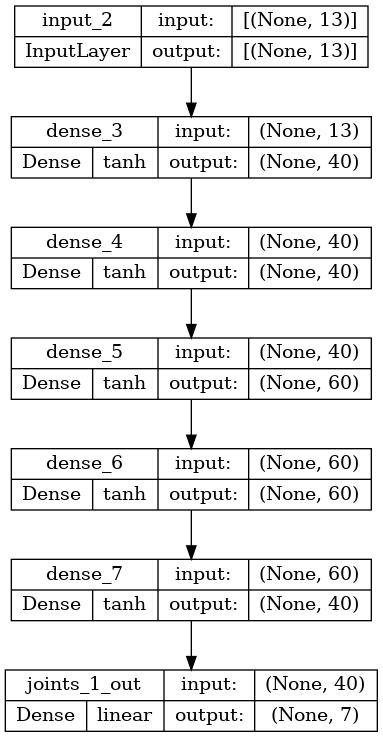

In [13]:
from keras.utils import plot_model

plot_model(
    inv_transform,
    to_file='../../plots/kuka/kinematics/kuka_inv_transform_6l.png',
    show_shapes=True,
    show_layer_names=True,
    show_layer_activations=True
)

In [33]:
inv_transform.compile(
    optimizer=AdamW(learning_rate=0.001, weight_decay=0.004),
    loss={
        # 'joints_0_out': MeanSquaredError(),
        # 'eff_0_out': MeanSquaredError(),
        'joints_1_out': MeanSquaredError(),
        # 'eff_1_out': MeanSquaredError()
    },
    metrics={
        # 'joints_0_out': [MeanAbsoluteError()],
        # 'eff_0_out': [MeanAbsoluteError()],
        'joints_1_out': [MeanAbsoluteError()],
        # 'eff_1_out': [MeanAbsoluteError()]
    }
)

inv_transform_history = inv_transform.fit(
    x=X_inv_train_reduced,
    y={
        # 'joints_0_out': X_inv_train_joints_0,
        # 'eff_0_out': X_inv_train_eff_0,
        'joints_1_out': X_inv_train_joints_1,
        # 'eff_1_out': X_inv_train_eff_1
    },
    batch_size=1024,
    epochs=2000,
    callbacks=[TensorBoard(write_graph=False)],
    validation_split=0.2,
    shuffle=True
)

Epoch 1/50
313/313 [==============================] - 4s 7ms/step - loss: 0.0763 - mean_absolute_error: 0.1333 - val_loss: 0.0020 - val_mean_absolute_error: 0.0329
Epoch 2/50
313/313 [==============================] - 2s 6ms/step - loss: 0.0011 - mean_absolute_error: 0.0242 - val_loss: 7.0808e-04 - val_mean_absolute_error: 0.0202
Epoch 3/50
313/313 [==============================] - 2s 6ms/step - loss: 6.4418e-04 - mean_absolute_error: 0.0190 - val_loss: 5.9683e-04 - val_mean_absolute_error: 0.0180
Epoch 4/50
313/313 [==============================] - 2s 6ms/step - loss: 5.6826e-04 - mean_absolute_error: 0.0175 - val_loss: 5.4485e-04 - val_mean_absolute_error: 0.0170
Epoch 5/50
313/313 [==============================] - 2s 6ms/step - loss: 5.2636e-04 - mean_absolute_error: 0.0165 - val_loss: 5.0778e-04 - val_mean_absolute_error: 0.0160
Epoch 6/50
313/313 [==============================] - 2s 6ms/step - loss: 4.9230e-04 - mean_absolute_error: 0.0156 - val_loss: 4.7734e-04 - val_mean_abs

KeyboardInterrupt: 

In [ ]:
inv_transform.save('../../models/kinematics/kuka_inv_transform_3to1_6l_4000ep.keras')

In [6]:
inv_transform = load_model('../../models/kinematics/kuka_inv_transform_3to1_6l_4000ep.keras')

joints_0_in = Input(shape=(n_joints,), name='joints_0_in')
eff_0_in = Input(shape=(3,), name='eff_0_in')
eff_1_in = Input(shape=(3,), name='eff_1_in')

transform_in = Concatenate()([joints_0_in, eff_0_in, eff_1_in])
joints_1_out = inv_transform(transform_in, training=False)

base_in = Concatenate()([joints_0_in, eff_0_in, joints_1_out, eff_1_in])
act_out = inv_base(base_in, training=False)

inv_full = Model(
    inputs=[joints_0_in, eff_0_in, eff_1_in],
    outputs=act_out,
    name='inv_full'
)

inv_full.trainable = False

inv_full.compile(
    optimizer=Adam(learning_rate=0.001),
    loss={'inv_base': MeanSquaredError()},
    metrics={'inv_base': [MeanAbsoluteError()]}
)

inv_full.summary(
    expand_nested=True,
    show_trainable=True
)

Model: "inv_full"
_____________________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  Trainable  
 joints_0_in (InputLayer)    [(None, 7)]                  0         []                            N          
                                                                                                             
 eff_0_in (InputLayer)       [(None, 3)]                  0         []                            N          
                                                                                                             
 eff_1_in (InputLayer)       [(None, 3)]                  0         []                            N          
                                                                                                             
 concatenate (Concatenate)   (None, 13)                   0         ['joints_0_in[0][0]',         N   

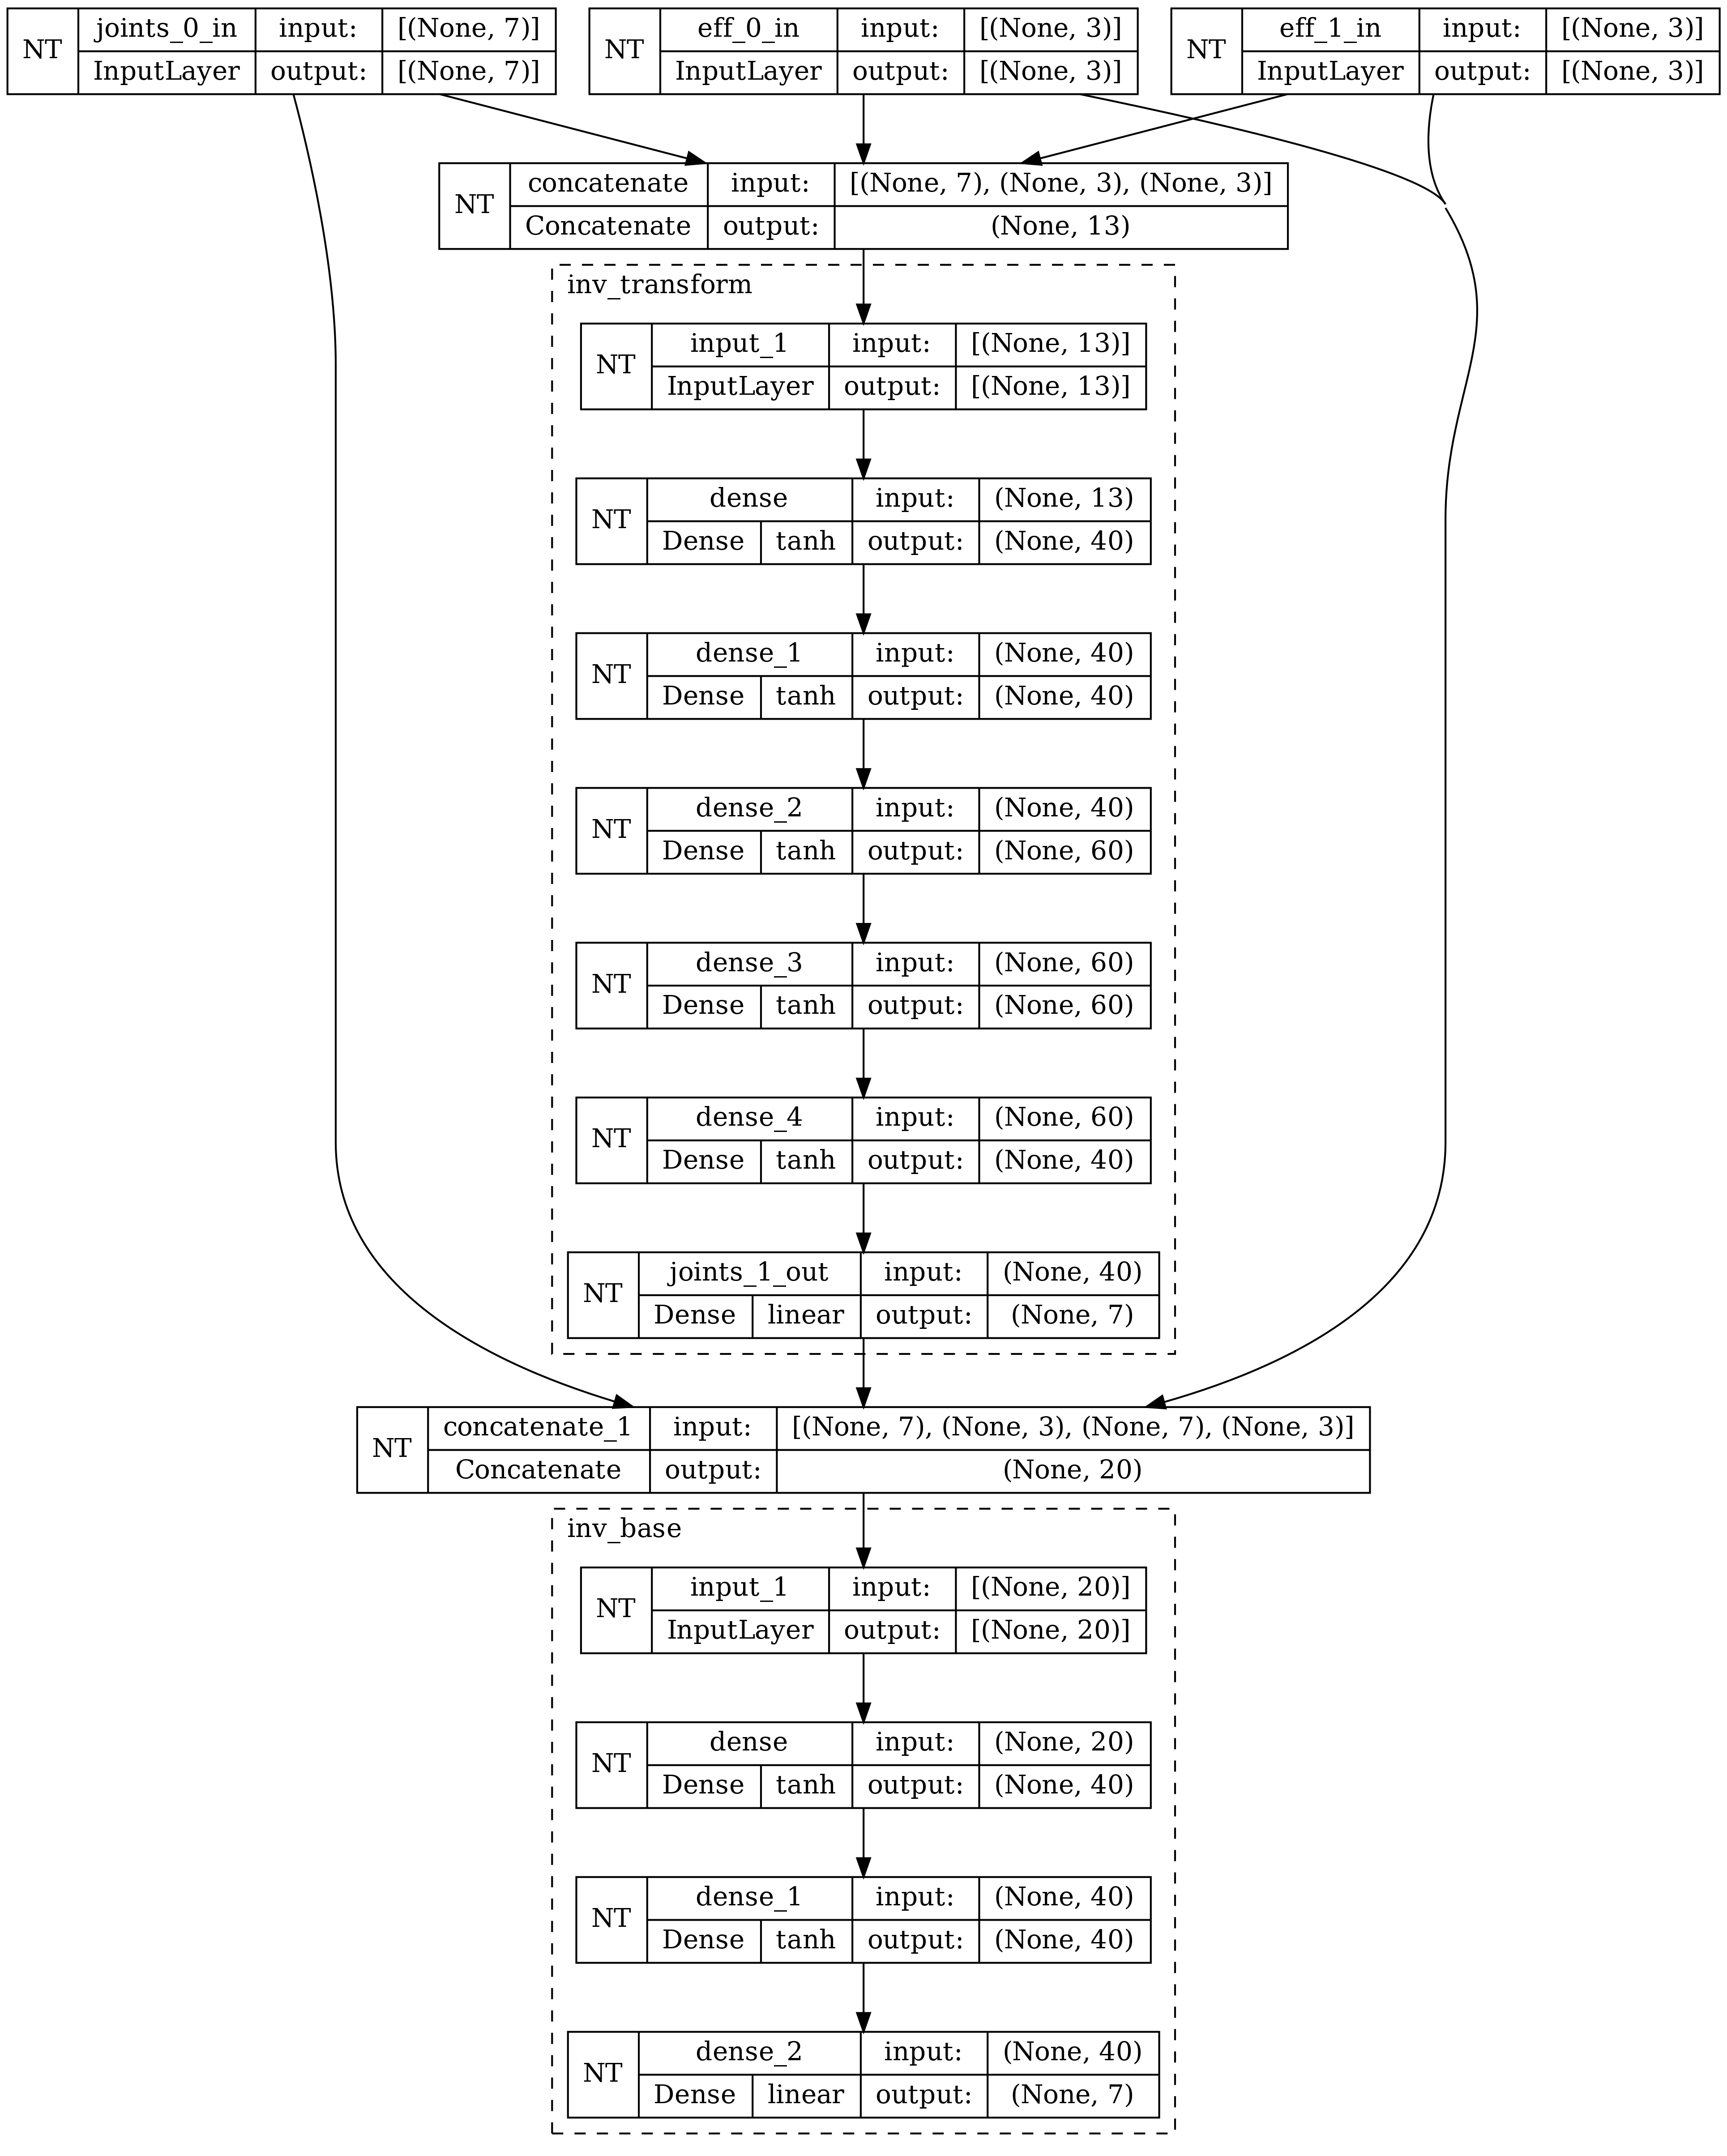

In [8]:
from keras.utils import plot_model

plot_model(
    inv_full,
    to_file='../../plots/kuka/kinematics/kuka_inv_transform_full.png',
    show_shapes=True,
    show_layer_names=True,
    show_layer_activations=True,
    expand_nested=True,
    show_trainable=True,
    dpi=300
)

In [27]:
inv_full.layers

In [9]:
inv_full.evaluate(
    x={
        'joints_0_in': X_inv_test_joints_0,
        'eff_0_in': X_inv_test_eff_0,
        'eff_1_in': X_inv_test_eff_1
    },
    y=y_inv_test,
    batch_size=1024,
    return_dict=True
)

98/98 [==============================] - 1s 8ms/step - loss: 0.0036 - mean_absolute_error: 0.0481


{'loss': 0.0035568876191973686, 'mean_absolute_error': 0.048088882118463516}

In [10]:
inv_full.predict(
    [
        np.expand_dims(X_inv_test_joints_0[0], axis=0),
        np.expand_dims(X_inv_test_eff_0[0], axis=0),
        np.expand_dims(X_inv_test_eff_1[0], axis=0)
    ]
)

1/1 [==============================] - 1s 568ms/step


array([[ 0.02551755, -0.05128101, -0.00388683, -0.02128286, -0.04085202,
         0.00137757,  0.00610107]], dtype=float32)

In [11]:
inv_full.save('../../models/kinematics/kuka_inv_transform_full.keras')